In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#get versions of packages
import sys
print(sys.version)
print(pd.__version__)
import scipy
print(scipy.__version__)

3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21) 
[GCC 10.3.0]
1.5.0
1.9.1


In [3]:
#load data frames (bt = bundestag, tw = twitter)
mappings = pd.read_excel("../data/topic_mapping_FINAL.xlsx")
tw_topics = pd.read_excel("../data/twitter_model_Super_FINAL.xlsx")
bt_topics = pd.read_excel("../data/parl_model_Super_FINAL.xlsx")

print(list(mappings.columns))
print(list(tw_topics.columns))
print(list(bt_topics.columns))


['debate_topic', 'debate_index', 'twitter_1_topic', 'twitter_1_index', 'twitter_2_topic', 'twitter_2_index', 'twitter_3_topic', 'twitter_3_index', 'score', 'Lawrence', 'Kris', 'Jona', 'SUM', 'Unnamed: 13', 'FINAL CHOICE', 'Notes']
['Unnamed: 0', 'Topic', 'Count', 'Name', 'Representation', 'Representative_Docs', 'Super_Topic', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12']
['Unnamed: 0', 'Topic', 'Count', 'Name', 'Representation', 'Representative_Docs', 'Super_Topic', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']


In [4]:
#filter unnecessary columns
mappings = mappings.filter(items = ["debate_index", "twitter_1_index", "twitter_2_index", "twitter_3_index", "FINAL CHOICE"])
mappings.rename(columns = {"debate_index":"bt_idx", "twitter_1_index":"tw1_idx", "twitter_2_index":"tw2_idx", "twitter_3_index":"tw3_idx", "FINAL CHOICE":"choice"}, inplace = True)

tw_topics = tw_topics.filter(items = ["Topic", "Count", "Super_Topic"])
bt_topics = bt_topics.filter(items = ["Topic", "Count", "Super_Topic"])

In [5]:
print(mappings.head())
print(tw_topics.head())
print(bt_topics.head())

   bt_idx  tw1_idx  tw2_idx  tw3_idx  choice
0      24       27        9       14       1
1      30       25       80       59       1
2      42       55       44       14       1
3       5        9       80       97       1
4     124       56       51       49       1
   Topic   Count Super_Topic
0     -1  204638   Sonstiges
1      0   45824   Sonstiges
2      1   24616   Sonstiges
3      2   21305   Sonstiges
4      3   19439   Sonstiges
   Topic  Count         Super_Topic
0     -1   9129           Sonstiges
1      0    563          Gesundheit
2      1    534           Sonstiges
3      2    461           Sonstiges
4      3    422  Inneres und Heimat


In [6]:
#create data frame with column containing matched twitter topic index

data = mappings.copy()

def choose_topic(row):
    if row["choice"] == 0:
        return np.nan
    if row["choice"] == 1:
        return row["tw1_idx"]
    if row["choice"] == 2:
        return row["tw2_idx"]
    if row["choice"] == 3:
        return row["tw3_idx"]
    else:
        return "ERROR"
    
data["tw_topic"] = data.apply(choose_topic, axis = 1)


In [7]:
#verify correct matching
print(data["choice"].value_counts())
print(data[data["choice"] == 0].head())
print(data[data["choice"] == 0].shape)
print(data[data["choice"] == 1].head())
print(data[data["choice"] == 1].shape)
print(data[data["choice"] == 2].head())
print(data[data["choice"] == 2].shape)
print(data[data["choice"] == 3].head())
print(data[data["choice"] == 3].shape)

0    67
1    58
2     7
3     1
Name: choice, dtype: int64
    bt_idx  tw1_idx  tw2_idx  tw3_idx  choice  tw_topic
28      14       15       14       82       0       NaN
30      17       50       15       97       0       NaN
35     103       30        0       21       0       NaN
39      76       75       15       50       0       NaN
41      -1        0       80       47       0       NaN
(67, 6)
   bt_idx  tw1_idx  tw2_idx  tw3_idx  choice  tw_topic
0      24       27        9       14       1      27.0
1      30       25       80       59       1      25.0
2      42       55       44       14       1      55.0
3       5        9       80       97       1       9.0
4     124       56       51       49       1      56.0
(58, 6)
    bt_idx  tw1_idx  tw2_idx  tw3_idx  choice  tw_topic
42     110       58       31       15       2      31.0
50     106       58       23       15       2      23.0
67      29        4       53        6       2      53.0
68      83       50       43       

In [8]:
#drop rows with unmatched topics
data.dropna(axis = 0, inplace = True)
data = data.astype({"tw_topic" : int})
print(data.head())
print(data.shape)

   bt_idx  tw1_idx  tw2_idx  tw3_idx  choice  tw_topic
0      24       27        9       14       1        27
1      30       25       80       59       1        25
2      42       55       44       14       1        55
3       5        9       80       97       1         9
4     124       56       51       49       1        56
(66, 6)


In [9]:
#create dictionaries with the counts for each topic
tw_topic_counts = dict()
bt_topic_counts = dict()

for i, row in tw_topics.iterrows():
    tw_topic_counts[row["Topic"]] = row["Count"]

for i, row in bt_topics.iterrows():
    bt_topic_counts[row["Topic"]] = row["Count"]

In [10]:
#create column with number of documents for twitter topics
def get_tw_count(row):
    return tw_topic_counts[row["tw_topic"]]

data["tw_count"] = data.apply(get_tw_count, axis = 1)

In [11]:
print(data.head())

   bt_idx  tw1_idx  tw2_idx  tw3_idx  choice  tw_topic  tw_count
0      24       27        9       14       1        27      2055
1      30       25       80       59       1        25      2180
2      42       55       44       14       1        55       856
3       5        9       80       97       1         9      5628
4     124       56       51       49       1        56       838


In [12]:
#create dictionary containing all bt topics matched onto any tw topic
matched_topics = dict()

for i in pd.unique(data["tw_topic"]):
    matched_topics[i] = []

for i, row in data.iterrows():
    matched_topics[row["tw_topic"]].append(row["bt_idx"])

print(matched_topics)

{27: [24], 25: [30], 55: [42], 9: [5], 56: [124], 29: [31, 77, 73], 50: [57], 41: [28], 34: [26], 28: [51], 71: [10], 35: [75], 85: [35, 97], 97: [80, 91], 37: [21, 101], 53: [78, 29], 10: [11], 73: [84], 44: [118], 91: [93], 68: [34], 36: [53], 75: [32], 83: [113], 15: [102], 0: [2], 43: [22, 83], 4: [15, 74, 36], 54: [18, 94], 13: [25], 33: [55], 31: [130, 110], 38: [3], 23: [86, 106], 20: [19], 11: [6, 49, 105], 7: [0], 78: [119], 45: [58], 22: [7], 70: [121], 69: [59], 72: [16], 46: [85], 6: [13, 4, 112], 8: [9, 43], 77: [65], 42: [114], 47: [96]}


In [13]:
#create column with all matched bt topics for tw topics
def assign_bt(row):
    return matched_topics[row["tw_topic"]]

data["bt_topics"] = data.apply(assign_bt, axis = 1)

In [14]:
print(data.shape)
data

(66, 8)


,bt_idx,tw1_idx,tw2_idx,tw3_idx,choice,tw_topic,tw_count,bt_topics
0,24,27,9,14,1,27,2055,[24]
1,30,25,80,59,1,25,2180,[30]
2,42,55,44,14,1,55,856,[42]
3,5,9,80,97,1,9,5628,[5]
4,124,56,51,49,1,56,838,[124]
...,...,...,...,...,...,...,...,...
99,91,97,64,14,1,97,315,"[80, 91]"
101,105,11,6,43,1,11,5062,"[6, 49, 105]"
106,43,50,15,8,3,8,7900,"[9, 43]"
110,73,29,0,80,1,29,1709,"[31, 77, 73]"


In [15]:
#with all bt topics matched to any tw topic contained in bt_topics column as a list, can drop duplicate rows
data.drop_duplicates(subset = ["tw_topic"], keep = "first", inplace = True)
print(data.head())
print(data.tail())
print(data.shape)

   bt_idx  tw1_idx  tw2_idx  tw3_idx  choice  tw_topic  tw_count bt_topics
0      24       27        9       14       1        27      2055      [24]
1      30       25       80       59       1        25      2180      [30]
2      42       55       44       14       1        55       856      [42]
3       5        9       80       97       1         9      5628       [5]
4     124       56       51       49       1        56       838     [124]
     bt_idx  tw1_idx  tw2_idx  tw3_idx  choice  tw_topic  tw_count  \
58       13        6        0       43       1         6     10450   
61        9        8        0        6       1         8      7900   
65       65       77       36        0       1        77       482   
85      114       42       78       80       1        42      1287   
127      96        0       47       91       2        47      1065   

        bt_topics  
58   [13, 4, 112]  
61        [9, 43]  
65           [65]  
85          [114]  
127          [96]  
(49, 8)


In [16]:
#count number of bt documents containing the various bt topics matched to tw topics
def get_bt_count(row):
    count = 0
    for i in row["bt_topics"]:
        count += bt_topic_counts[i]
    return count

data["bt_count"] = data.apply(get_bt_count, axis = 1)

In [17]:
#drop unnecessary columns for further analysis
data = data.filter(items = ["tw_topic", "tw_count", "bt_topics", "bt_count"])

print(data.head())
print(data.tail())
print(data.shape)

   tw_topic  tw_count bt_topics  bt_count
0        27      2055      [24]       111
1        25      2180      [30]        94
2        55       856      [42]        53
3         9      5628       [5]       326
4        56       838     [124]        13
     tw_topic  tw_count     bt_topics  bt_count
58          6     10450  [13, 4, 112]       561
61          8      7900       [9, 43]       290
65         77       482          [65]        36
85         42      1287         [114]        15
127        47      1065          [96]        21
(49, 4)


In [18]:
# data.to_excel("topic_data.xlsx", index = False)

<AxesSubplot:xlabel='bt_count', ylabel='tw_count'>

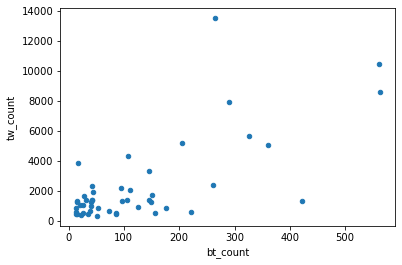

In [19]:
#scatterplot
data[data["tw_count"] <= 20000].plot.scatter(x = "bt_count", y = "tw_count")

In [20]:
#calculate correlation coefficients
bt_counts = data["bt_count"]
tw_counts = data["tw_count"]

spearman_r_topics = stats.spearmanr(bt_counts, tw_counts)
kendall_tau_topics = stats.kendalltau(bt_counts, tw_counts)
pearson_r_topics = stats.pearsonr(bt_counts, tw_counts)

In [21]:
print(spearman_r_topics)
print(kendall_tau_topics)
print(pearson_r_topics)

#test for normal distribution
print(stats.shapiro(bt_counts))
print(stats.shapiro(tw_counts))

SpearmanrResult(correlation=0.5634823550744922, pvalue=2.4920432938862652e-05)
KendalltauResult(correlation=0.40000178214601567, pvalue=5.25794828202434e-05)
(0.5745754246756333, 1.579176297270281e-05)
ShapiroResult(statistic=0.7786471843719482, pvalue=3.5893071981263347e-07)
ShapiroResult(statistic=0.38524365425109863, pvalue=4.935771843322945e-13)


In [22]:
#remove outliers with especially high document count on twitter (especially topic 0)
data_wo_out = data.drop(data[data["tw_count"] > 20000].index)
print(data_wo_out.shape)


(48, 4)


In [23]:
#recalculate correlations
bt_counts_2 = data_wo_out["bt_count"]
tw_counts_2 = data_wo_out["tw_count"]

spearman_r_topics_2 = stats.spearmanr(bt_counts_2, tw_counts_2)
kendall_tau_topics_2 = stats.kendalltau(bt_counts_2, tw_counts_2)
pearson_r_topics_2 = stats.pearsonr(bt_counts_2, tw_counts_2)

In [24]:
print(spearman_r_topics_2)
print(kendall_tau_topics_2)
print(pearson_r_topics_2)

#test for normal distribution
print(stats.shapiro(bt_counts_2))
print(stats.shapiro(tw_counts_2))

#get total document counts
print(np.sum(bt_counts_2))
print(np.sum(tw_counts_2))


SpearmanrResult(correlation=0.5361563644331356, pvalue=8.576482132148484e-05)
KendalltauResult(correlation=0.37794758437933157, pvalue=0.0001577368610780622)
(0.7012939907575192, 2.8309115393756073e-08)
ShapiroResult(statistic=0.7707504630088806, pvalue=3.010194120633969e-07)
ShapiroResult(statistic=0.6639654636383057, pvalue=3.235217427288717e-09)
5972
109687


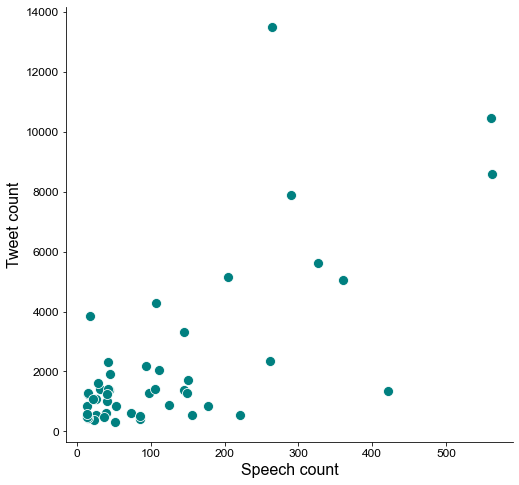

In [25]:
#create a nicer plot

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data = data_wo_out, x = "bt_count", y = "tw_count", ax = ax, s = 100, color = "teal")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Speech count", fontsize = 16, fontname = "Arial")
ax.set_ylabel("Tweet count", fontsize = 16, fontname = "Arial")
plt.xticks(fontsize = 12, fontname = "Arial")
plt.yticks(fontsize = 12, fontname = "Arial")
fig.patch.set_facecolor('white')

#plt.savefig("topic_plot_paper.png", dpi = 300, transparent = False)

In [26]:
#aggregate document counts from bt by super topic
bt_super = bt_topics.copy()
bt_super.drop(columns = "Topic", inplace = True)
bt_super = bt_super.groupby(by = "Super_Topic", dropna = False).sum()
bt_super.rename(columns = {"Count":"bt_count"}, inplace = True)

In [27]:
#aggregate document counts from tw by super topic
tw_super = tw_topics.copy()
tw_super.drop(columns = "Topic", inplace = True)
tw_super = tw_super.groupby(by = "Super_Topic", dropna = False).sum()
tw_super.rename(columns = {"Count":"tw_count"}, inplace = True)

In [28]:
print(bt_super)
print(tw_super)

                                             bt_count
Super_Topic                                          
Arbeit und Soziales                               334
Auswärtiges Amt                                  1618
Bau                                               274
Bildung und Forschung                             320
Digitale Infrastruktur                            211
Energie                                           205
Ernährung                                          14
Familie, Senioren, Frauen und Jugend              722
Finanzen                                          725
Gesundheit                                       1128
Inneres und Heimat                                929
Justiz                                            301
Landwirtschaft                                    290
Sonstiges                                       10734
Umwelt, Naturschutz und nukleare Sicherheit       337
Verbraucherschutz                                 102
Verkehr                     

In [29]:
#combine dataframes for super topics, drop category "Sonstiges"
super_topics = bt_super.merge(tw_super, how = "outer", on = "Super_Topic")
super_topics.fillna(value = 0, inplace = True)
super_topics.drop(index = "Sonstiges", inplace = True)
super_topics = super_topics.astype({"bt_count":int, "tw_count":int})
print(super_topics)

                                             bt_count  tw_count
Super_Topic                                                    
Arbeit und Soziales                               334      1266
Auswärtiges Amt                                  1618     22937
Bau                                               274      4734
Bildung und Forschung                             320         0
Digitale Infrastruktur                            211      1888
Energie                                           205      1304
Ernährung                                          14       564
Familie, Senioren, Frauen und Jugend              722     14865
Finanzen                                          725     12317
Gesundheit                                       1128     19316
Inneres und Heimat                                929     15179
Justiz                                            301         0
Landwirtschaft                                    290      2229
Umwelt, Naturschutz und nukleare Sicherh

<AxesSubplot:xlabel='bt_count', ylabel='tw_count'>

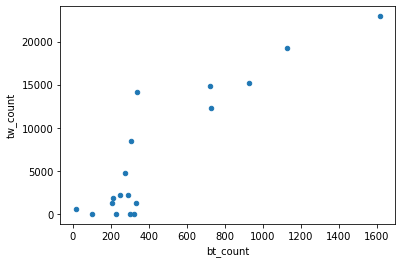

In [30]:
#scatterplot for super topics document counts
super_topics.plot.scatter(x = "bt_count", y = "tw_count")

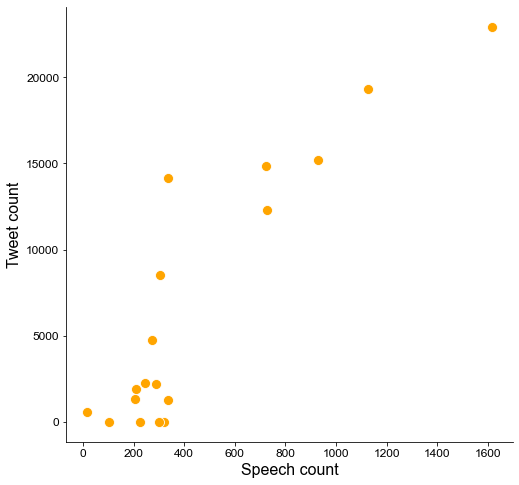

In [31]:
#create a nicer plot

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data = super_topics, x = "bt_count", y = "tw_count", ax = ax, s = 100, color = "orange")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Speech count", fontsize = 16, fontname = "Arial")
ax.set_ylabel("Tweet count", fontsize = 16, fontname = "Arial")
plt.xticks(fontsize = 12, fontname = "Arial")
plt.yticks(fontsize = 12, fontname = "Arial")
fig.patch.set_facecolor('white')

#plt.savefig("supert_plot_paper.png", dpi=300, transparent = False)

In [32]:
#calculate correlation coefficients for super topics
super_bt = super_topics["bt_count"]
super_tw = super_topics["tw_count"]

spearman_r_super = stats.spearmanr(super_bt, super_tw)
kendall_tau_super = stats.kendalltau(super_bt, super_tw)
pearson_r_super = stats.pearsonr(super_bt, super_tw)

In [33]:
print(spearman_r_super)
print(kendall_tau_super)
print(pearson_r_super)

#get total document counts
print(np.sum(super_bt))
print(np.sum(super_tw))

#test for normal distribution
print(stats.shapiro(super_bt))
print(stats.shapiro(super_tw))

SpearmanrResult(correlation=0.7427485800215359, pvalue=0.0004140519157840193)
KendalltauResult(correlation=0.6201240372124044, pvalue=0.00039301073748266056)
(0.8933740671594556, 5.983225051588125e-07)
8284
121518
ShapiroResult(statistic=0.7882184386253357, pvalue=0.0010403756750747561)
ShapiroResult(statistic=0.822726845741272, pvalue=0.0032400430645793676)


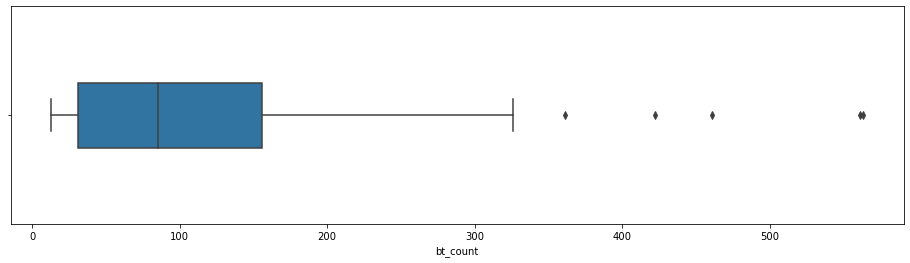

In [34]:
#boxplots for topic data
plt.figure(figsize=(16, 4))
bt_bplot = sns.boxplot(x = bt_counts, width = 0.3)

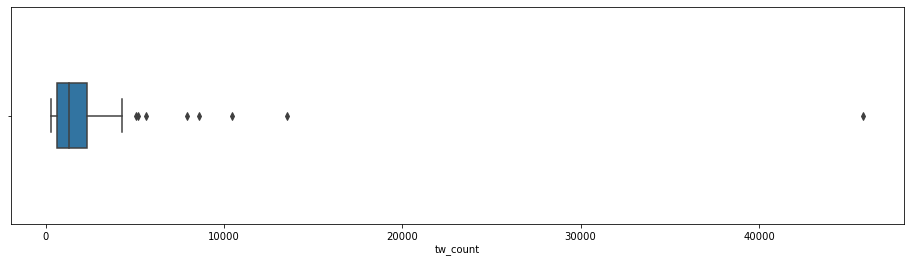

In [35]:
plt.figure(figsize=(16, 4))
tw_bplot = sns.boxplot(x = tw_counts, width = 0.3)

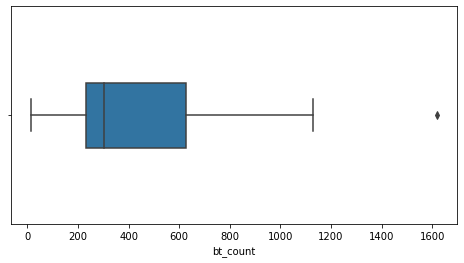

In [36]:
#boxplots for super topics
plt.figure(figsize=(8, 4))
bt_super_bplot = sns.boxplot(x = super_bt, width = 0.3)

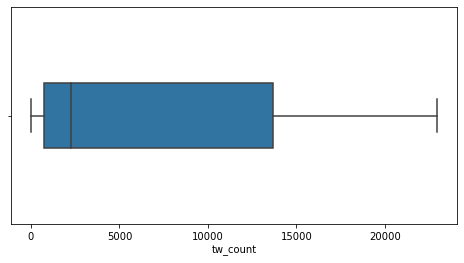

In [37]:
plt.figure(figsize=(8, 4))
tw_super_bplot = sns.boxplot(x = super_tw, width = 0.3)